# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [10]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [11]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
#     if prt: print('n,k,cl',n,k,cl)
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [12]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)
        
bell_dict = {}

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [22]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites, param_name, curr_params):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites, param_name, curr_params)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def brute_force_sample (cluster_constraints, uf, config):
    '''Randomly sample a color for each cluster'''
    for root in cluster_constraints:
        max_col = cluster_constraints[root]
        cluster_color = np.random.choice((np.arange(1, max_col+1)))
        for site_str in uf.component(root):
            site = str2site(site_str)
            config[site[0],site[1]] = cluster_color
    return config


def sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf=None, cluster_constraints=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field and gamma > 0
    if (curr_params['alpha']==0 and curr_params['gamma']>0):
        if prt: print('Case with no field and gamma > 0')
            
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Only compute average in case with zero field and no interaction, but with gamma > 0,
               use an arbitray partition (avoid computing Bell polynomials)
            '''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        partition_dict = {}
        if ((no_cl,exact_k) in bell_dict):
            partition_dict = bell_dict[(no_cl,exact_k)]
            if prt: print ("Bell found", (no_cl,exact_k))
        else:
            session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
            partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs], subs]")
            bell_dict[(no_cl,exact_k)] = partition_dict
            if prt: print ("Bell computed", (no_cl,exact_k))
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for root in cluster_constraints:
            cluster_color = color_arr[i]
            for site_str in uf.component(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field and gamma > 0 or case with gamma = 0
    else:
        if prt: print('Case with field and gamma > 0 or case with gamma = 0')
            
        '''Randomly sample a color for each cluster'''
        config = brute_force_sample (cluster_constraints, uf, config)
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites, param_name, curr_params):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force until compatible with eta_lambda
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [23]:
only_averages = False
prt = True
N, no_cols = 4, 16
gamma = 2    # strength of preference for low no. of cols
J = 1        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)
curr_params = {}
curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
param_name = "Alpha"

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)
for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

session.terminate()

lambda probabilities: [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
edge probabilities: [0.86466472 0.13533528]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[15 10 14  2]
 [12 14 14 10]
 [ 5  3  8 11]
 [ 1  2  7  7]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 11
assigned no. cols (eta_lambda): 11
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 1  1  0  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]]



Bell found (13, 9)
partition_dict {(8, 0, 0, 0, 1): 1287, (7, 1, 0, 1, 0): 25740, (7, 0, 2, 0, 0): 17160, (6, 2, 1, 0, 0): 180180, (5, 4, 0, 0, 0): 135135}
partition_p: [1287, 25740, 17160, 180180, 135135]
partition_p: [0.003579952267303103, 0.07159904534606205, 0.0477326968973747, 0.5011933174224343, 0.37589498806682575]
chosen partition:
(5, 4, 0, 0, 0)
chosen partition:
[1, 1, 1, 1, 1, 2, 2, 2, 2]
colors for clusters:
[ 2 14  8  2  4 14  3  1  5  5 16  9  8]
config:
[[ 2 14 14  8]
 [ 2  4 14 14]
 [ 3  1  5  5]
 [16  9  8  5]]

-------------------- iter 5 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 9
assigned no. cols (eta_lambda): 9
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (

[1 9]
config:
[[1 1 1 9]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

-------------------- iter 30 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  0  0  1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]]

[[ 1  0  1 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 1 2]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
Case with no field and gamma > 0
prob_k: [16, 240]
prob_k: [0.0625 0.9375]
exact

clusters formed by bonds (eta_edge):
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
Case with no field and gamma > 0
prob_k: [16]
prob_k: [1.]
exact number of colors to use in configuration:
1
Bell found (1, 1)
partition_dict {(1,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(1,)
chosen partition:
[1]
colors for clusters:
[2]
config:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]

-------------------- iter 65 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 1
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  0  0  1]
 [ 0  0  1  1]
 [ 1  0  0  0]
 [-1 -1 -1 -1]]

[[ 0  0  0 -1]
 [ 1  0  0 -1]
 [ 1  1  0 -1]
 [ 0  0  0 -1]]
probab

prob_k: [3.05101294e-05 6.86477911e-03 1.60178179e-01 8.32926532e-01]
exact number of colors to use in configuration:
4
Bell found (5, 4)
partition_dict {(3, 1): 10}
partition_p: [10]
partition_p: [1.0]
chosen partition:
(3, 1)
chosen partition:
[1, 1, 1, 2]
colors for clusters:
[10 15 16 14 10]
config:
[[10 15 15 15]
 [16 15 15 15]
 [14 14 15 10]
 [14 15 15 15]]

final config:
[[10 15 15 15]
 [16 15 15 15]
 [14 14 15 10]
 [14 15 15 15]]


## Full simulation

In [16]:
def init_edge_prob (J):
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    return edge_prob
    
def init_site_prob (alpha, no_cols):
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    return site_prob

def init_lambda_prob (gamma, no_cols):
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    return lambda_prob

In [17]:
def experiment_full_interaction (N, no_cols, gamma=0, J=0, alpha=0, gammas=None, Js=None, alphas=None):
    '''Run simulation for different parameters given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Identify varying parameter'''
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    params = None
    param_name = "None"
    for pms,pname in [(gammas,"Gamma"), (Js,"J"), (alphas,"Alpha")]:
        if pms is not None:
            params = pms
            param_name = pname
    nparam = len(params)
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = init_edge_prob(J)
    site_prob = init_site_prob(alpha, no_cols)   
    lambda_prob = init_lambda_prob(gamma, no_cols)
    print('edge probabilities:', edge_prob)
    print('site probabilities:', site_prob)
    print('lambda probabilities:', lambda_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nparam), np.zeros(nparam)
    std_c, std_s_c = np.zeros(nparam), np.zeros(nparam)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying params:', params)
    for iparam in range(nparam):
        
        '''Probabilities for the varying parameter'''
        param = params[iparam]
        print(iparam, ' - param:', param)
        if param_name=="Gamma":
            curr_params['gamma'] = param
            lambda_prob = init_lambda_prob(param, no_cols)
            print('lambda probabilities:', lambda_prob)
        elif param_name=="Alpha":
            curr_params['alpha'] = param
            site_prob = init_site_prob(param, no_cols)
            print('site probabilities:', site_prob)
        elif param_name=="J":
            curr_params['J'] = param
            edge_prob = init_edge_prob(param)
            print('edge probabilities:', edge_prob)
            
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[iparam] = tot_c / (mc_steps)
        avg_s_c[iparam] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iparam], avg_s_c[iparam])
        std_c[iparam] = np.std(no_cols_arr)
        std_s_c[iparam] = np.std(no_sites_arr)
        print('Final stds:', std_c[iparam], std_s_c[iparam])
        print('-'*120 + '\n')
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    if param_name=="Gamma":
        my_max_gamma = gammas[-1]
        my_gammas = np.linspace(0, my_max_gamma, num=200)
        z = [np.e**(-my_gamma) for my_gamma in my_gammas]
        y = [E_cols(N*N,zz,C) for zz in z]
        yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
        plt.errorbar(my_gammas, y, yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(params, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_.png", format="png")
    
#     plt.show()
    
    return params, avg_c, std_c

## J (edges / neighbor interaction) with multiple Gamma

In [18]:
def plot_multiple (params, avg_c, std_c, params2, param_name, param_name2):
    f = plt.figure(figsize=(18, 5)) 
    
    for i in range(len(params)):
        plt.errorbar(params[i], avg_c[i], std_c[i], linestyle='solid', capsize=3, marker='o',
                     label=(str(param_name2)+" = "+str(params2[i])) )

    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.legend()
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(N*N) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_.png", format="png")

    plt.show()

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[20  7 11 21  7]
 [ 4 12 21  7  1]
 [21 19 19  4  7]
 [13 24 23  5 14]
 [24  7  9 20 22]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 1.7857142857142858
101 num. cols: 16.04950495049505 avg. sites per col: 1.571403644634187
201 num. cols: 16.074626865671643 avg. sites per col: 1.5697821072890397
301 num. cols: 15.9568

401 num. cols: 14.86783042394015 avg. sites per col: 1.7036991028555295
501 num. cols: 14.920159680638722 avg. sites per col: 1.697178335171701
601 num. cols: 14.910149750415973 avg. sites per col: 1.6987727143997289
701 num. cols: 14.954350927246791 avg. sites per col: 1.6934641112258912
801 num. cols: 14.945068664169789 avg. sites per col: 1.6950471508809504
901 num. cols: 14.93007769145394 avg. sites per col: 1.6970678972715774
1001 num. cols: 14.883116883116884 avg. sites per col: 1.7022733090720839
Final configuration:
[[12 25 10  5  9]
 [ 3 18  5 18 10]
 [21 12  2 13 17]
 [ 2 14 10 17 22]
 [23 11  9  7  4]]
Final averages: 14.891542288557213 1.7014182460528524
Final stds: 1.6990421970966938 0.20081633938509655
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
Initial configuration
[[12  6 21  3  6]
 [ 7 24 19 24 14]
 [ 6 14 20  7  2]
 [ 3 21 18  1 21

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 4.166666666666667
101 num. cols: 5.287128712871287 avg. sites per col: 5.629723686654377
201 num. cols: 6.497512437810945 avg. sites per col: 4.506216213305763
301 num. cols: 5.840531561461794 avg. sites per col: 5.170778142123652
401 num. cols: 5.72568578553616 avg. sites per col: 5.126285116933499
501 num. cols: 6.429141716566866 avg. sites per col: 4.661036595916847
601 num. cols: 6.422628951747088 avg. sites per col: 4.687692599506248
701 num. cols: 6.1455064194008555 avg. sites per col: 4.968995084009352
801 num. cols: 6.390761548064919 avg. sites per col: 4.807876528382153
901 num. cols: 6.665926748057713 avg. sites per col: 4.606360697509428
1001 num. cols: 7.104895104895105 avg. sites per col: 4.381545028398171
Final configuration:
[[ 2 12 17 24 23]
 [ 2 19 20 25 23]
 [ 2 16 20 23 23]
 [16  3 23 23 23]
 [16 23 23 23 23

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.1293532338308458 avg. sites per col: 23.383084577114428
301 num. cols: 1.212624584717608 avg. sites per col: 22.3421926910299
401 num. cols: 1.2668329177057356 avg. sites per col: 21.706151288445557
501 num. cols: 1.4830339321357286 avg. sites per col: 20.088988689288144
601 num. cols: 1.4026622296173046 avg. sites per col: 20.906128674431546
701 num. cols: 1.3851640513552068 avg. sites per col: 20.99084640989067
801 num. cols: 1.3433208489388264 avg. sites per col: 21.4133374947982
901 num. cols: 1.3052164261931187 avg. sites per col: 21.81141324454313
1001 num. cols: 1.2747252747252746 avg. sites per col: 22.129953379953403
Final configuration:
[[18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.27363184

GAMMA: 1 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 7.80098743e-05 2.86982290e-05 1.05574884e-05
 3.88388295e-06 1.42880069e-06 5.25626399e-07 1.93367146e-07
 7.11357975e-08 2.61693974e-08 9.62718331e-09 3.54164282e-09
 1.30289758e-09 4.79309234e-10 1.76328013e-10 6.48674509e-11
 3.77513454e-11]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[24  7  7  9  5]
 [21  3  2 19  8]
 [ 8 18  6  9 20]
 [22 14 10 16 19]
 [ 5  3  2  3  9]]
equilibration step: 0
equilibration step: 1000
equilibration step

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 13.0 avg. sites per col: 1.9230769230769231
101 num. cols: 12.089108910891088 avg. sites per col: 2.0940624282208455
201 num. cols: 11.950248756218905 avg. sites per col: 2.113573270289683
301 num. cols: 12.375415282392026 avg. sites per col: 2.0497356664788735
401 num. cols: 12.239401496259351 avg. sites per col: 2.0775042093987386
501 num. cols: 12.165668662674651 avg. sites per col: 2.0949856651248
601 num. cols: 12.299500831946755 avg. sites per col: 2.072164368153892
701 num. cols: 12.315263908701855 avg. sites per col: 2.067979289202115
801 num. cols: 12.319600499375781 avg. sites per col: 2.0681416043830576
901 num. cols: 12.233074361820199 avg. sites per col: 2.0828652090077187
1001 num. cols: 12.222777222777223 avg. sites per col: 2.085268266678758
Final configuration:
[[ 7  5 13 14 18]
 [17  5  5 20 21]
 [ 5 10  5 17  7]
 [ 7  1  9  9 18]
 [ 9  1 18 20 18]]
Final averages: 12.2248756218905

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 2.3267326732673266 avg. sites per col: 13.345709570957093
201 num. cols: 2.2487562189054726 avg. sites per col: 13.061774461028197
301 num. cols: 2.548172757475083 avg. sites per col: 11.940753045404229
401 num. cols: 2.5885286783042396 avg. sites per col: 11.54984562403515
501 num. cols: 2.3013972055888225 avg. sites per col: 13.876889078984886
601 num. cols: 2.3643926788685525 avg. sites per col: 14.06932559490796
701 num. cols: 2.4465049928673324 avg. sites per col: 13.791706292597887
801 num. cols: 2.3957553058676653 avg. sites per col: 14.15426896934389
901 num. cols: 2.3895671476137625 avg. sites per col: 14.20373967196944
1001 num. cols: 2.387612387612388 avg. sites per col: 14.087648462648504
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0042796005706134 avg. sites per col: 24.946504992867332
801 num. cols: 1.00374531835206 avg. sites per col: 24.95318352059925
901 num. cols: 1.0033296337402886 avg. sites per col: 24.958379578246394
1001 num. cols: 1.002997002997003 avg. sites per col: 24.962537462537462
Final configuration:
[[18 18 18 18 18]
 [22 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.0049751243781095 24.937810945273633
Final stds: 0.07035888370015399 0.8794860462519246
---------------------------------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 2.272727272727273
101 num. cols: 9.227722772277227 avg. sites per col: 2.736273627362733
201 num. cols: 10.348258706467663 avg. sites per col: 2.4713898594495527
301 num. cols: 10.631229235880399 avg. sites per col: 2.394458623694498
401 num. cols: 10.82294264339152 avg. sites per col: 2.349282748285236
501 num. cols: 11.013972055888223 avg. sites per col: 2.3136585636585574
601 num. cols: 11.05657237936772 avg. sites per col: 2.3070073298858578
701 num. cols: 11.119828815977176 avg. sites per col: 2.290771520443406
801 num. cols: 11.184769038701623 avg. sites per col: 2.276933082176513
901 num. cols: 11.146503884572697 avg. sites per col: 2.281090779980887
1001 num. cols: 11.188811188811188 avg. sites per col: 2.27001783320465
Final configuration:
[[20  6 23 11 21]
 [17 19 12 20 21]
 [17 19 16 12  7]
 [ 7  6 12 19 19]
 [20  

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 9.148514851485148 avg. sites per col: 2.754025402540252
201 num. cols: 8.82587064676617 avg. sites per col: 2.891722014856338
301 num. cols: 8.564784053156146 avg. sites per col: 3.034721369438976
401 num. cols: 8.71072319201995 avg. sites per col: 2.965434572354775
501 num. cols: 8.7125748502994 avg. sites per col: 2.954163130061343
601 num. cols: 8.820299500831947 avg. sites per col: 2.9174028966042376
701 num. cols: 8.89586305278174 avg. sites per col: 2.8939558816520408
801 num. cols: 9.012484394506867 avg. sites per col: 2.8613353285638077
901 num. cols: 8.90899001109878 avg. sites per col: 2.8939241175645285
1001 num. cols: 8.724275724275724 avg. sites per col: 2.9639854539954444
Final configuration:
[[ 1 23 23 23  2]
 [ 1 23 23 23  6]
 [ 6  2 23 23  4]
 [25  8 25  8  8]
 [25  5  2  2  1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.1782178217821782 avg. sites per col: 22.77227722772277
201 num. cols: 1.472636815920398 avg. sites per col: 19.46517412935324
301 num. cols: 1.3322259136212624 avg. sites per col: 21.096345514950173
401 num. cols: 1.2493765586034913 avg. sites per col: 22.069825436408983
501 num. cols: 1.2574850299401197 avg. sites per col: 21.9311377245509
601 num. cols: 1.2146422628951747 avg. sites per col: 22.44176372712147
701 num. cols: 1.1840228245363766 avg. sites per col: 22.80670470756063
801 num. cols: 1.2172284644194757 avg. sites per col: 22.419891801914268
901 num. cols: 1.2097669256381798 avg. sites per col: 22.49815020347761
1001 num. cols: 1.1888111888111887 avg. sites per col: 22.748085248085243
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]

301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities: [0.97762923 0.02237077]
Initial configuration
[[14  6 23 25 19]
 [11  8  6 16  7]
 [ 5 24 23 16 15]
 [16 23 16 21  5]
 [15  3  4 21 16]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites 

201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.095577746077033 avg. sites per col: 6.130527817403709
801 num. cols: 4.2084893882646695 avg. sites per col: 5.989388264669164
901 num. cols: 4.296337402885682 avg. sites per col: 5.879578246392897
1001 num. cols: 4.3666333666333665 avg. sites per col: 5.791708291708292
Final configuration:
[[17 22  6  6  6]
 [17 14  6  6 22]
 [ 6 22 22  2 14]
 [22  6 22  2  2]
 [17 22 22  2 17]]
Final averages: 4.369154228855721 5.788557213930348
Final stds: 0.4825757807574465 0.6032197259468082
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[17 15  2 19 19]
 [10  1  2 18 15]
 [ 6 21 21  8 20]
 [24  6 23  3 23]
 [2

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[24 21 18 23  7]
 [ 6 17 25 24

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[18  8  6  8 22]
 [11 14 15  9 19]
 [ 8  3 13  9 23]
 

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 6.25
201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.0 avg. sites per col: 6.25
801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[ 2 18  3  3 18]
 [18 18 18  3 11]
 [ 3 11  2 18  2]
 [18 18 18  3 11]
 [ 3 11 11 18 11]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[13 10 10 25 13]
 [ 9  1 10  9

401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[ 1  8  6  6  2]
 [ 2  7 23 10 15]
 [ 8 17  8 17 12]
 [10 16 24 10 12]
 [ 5 25 23 19 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 nu

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[ 7 12 16  6 11]
 [22 10 23 11  3]
 [ 1 20 12 20  8]
 [1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



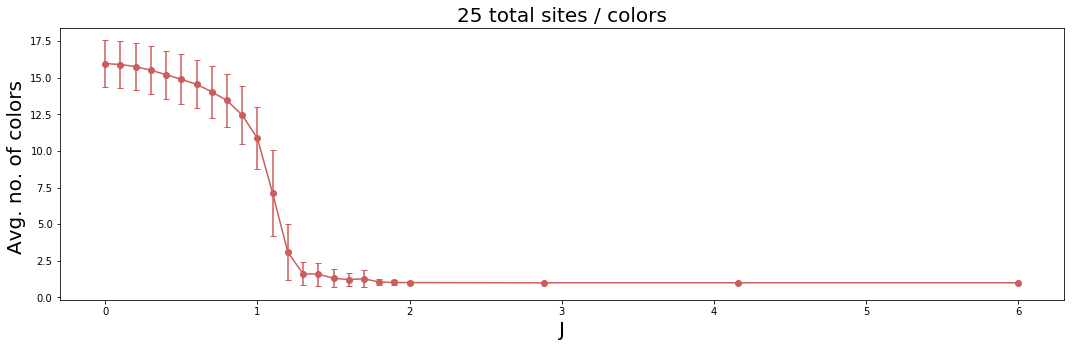

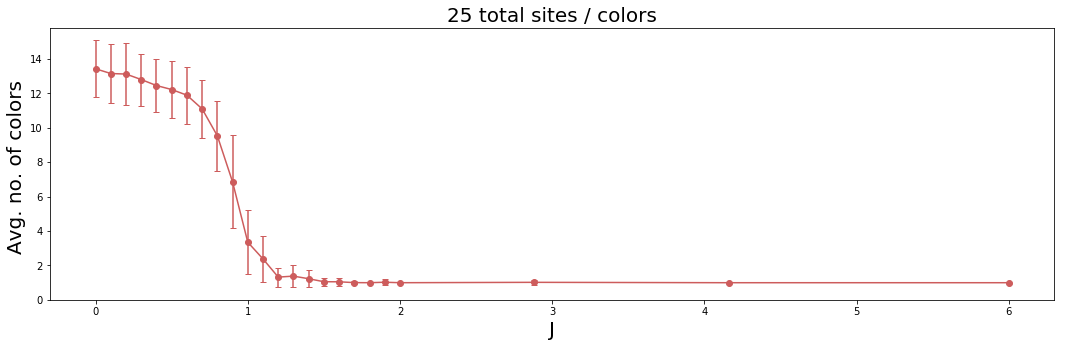

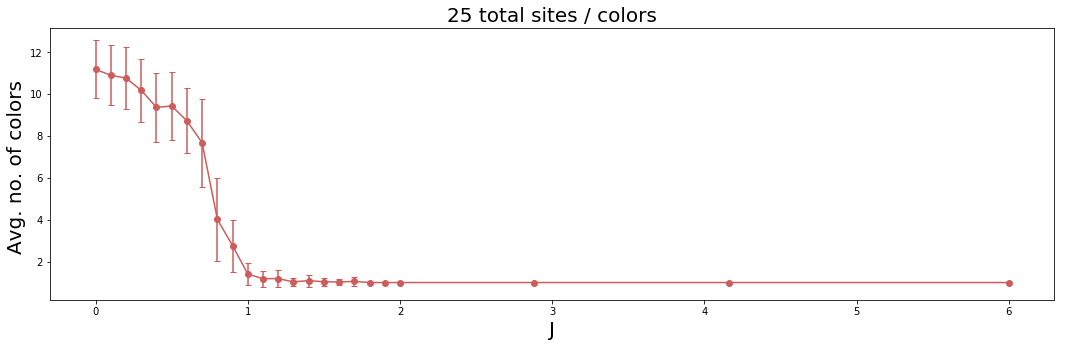

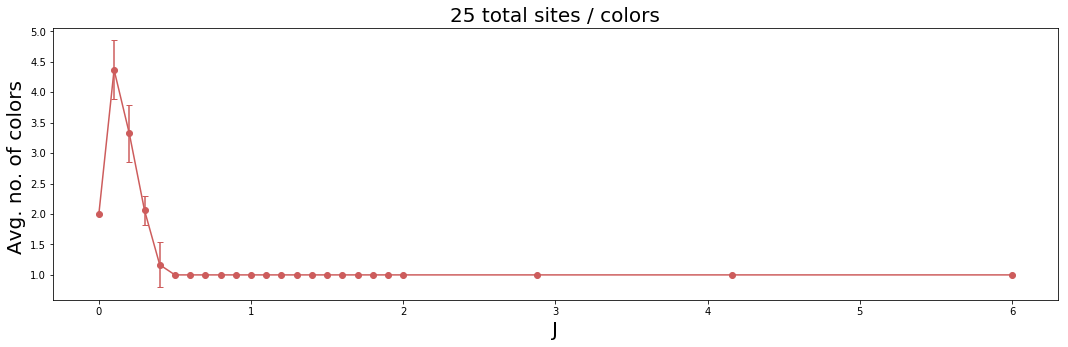

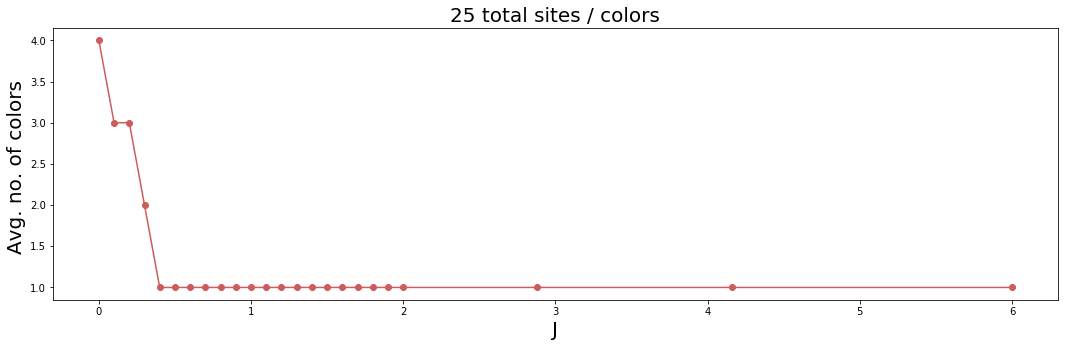

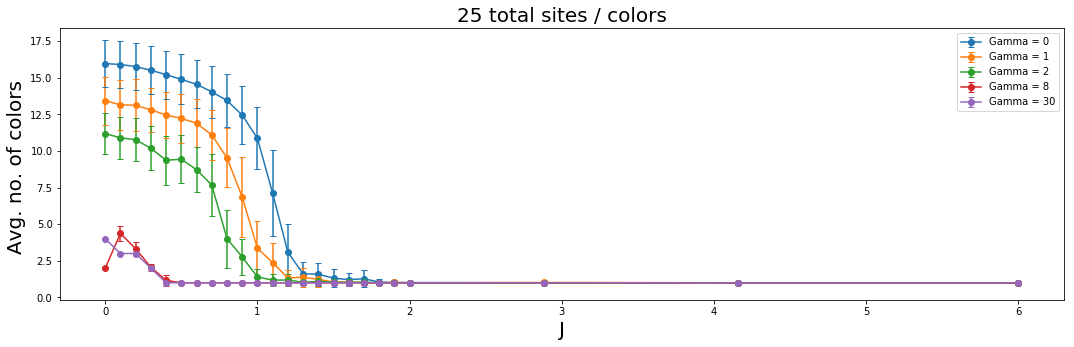

In [99]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 5

k=0
ngamma = 5
params, avg_c, std_c = [], [], []
gammas = [0,1,2,8,30]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[21 32 31 13 25 21]
 [ 2 24 12 10  4 36]
 [12 32 19  7  6 26]
 [30 31 28  3 22 28]
 [18 33 18  3  4 19]
 [23 15 10 31  4 27]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 23.0 avg. sites per col: 1.565217391304348
101 num. cols: 22.900990099009903 avg. sites per col: 1.585088123

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 22.0 avg. sites per col: 1.6363636363636365
101 num. cols: 21.782178217821784 avg. sites per col: 1.6650305458035928
201 num. cols: 21.781094527363184 avg. sites per col: 1.6661256924457424
301 num. cols: 21.893687707641195 avg. sites per col: 1.6567954930377249
401 num. cols: 21.90773067331671 avg. sites per col: 1.6563124393128357
501 num. cols: 21.860279441117765 avg. sites per col: 1.6596977727817208
601 num. cols: 21.848585690515808 avg. sites per col: 1.660795802090785
701 num. cols: 21.87731811697575 avg. sites per col: 1.6588155400022042
801 num. cols: 21.85143570536829 avg. sites per col: 1.660394611517549
901 num. cols: 21.862375138734738 avg. sites per col: 1.6595206724354858
1001 num. cols: 21.857142857142858 avg. sites per col: 1.6600563923995517
Final configuration:
[[14 36 24  7 32 34]
 [14  4 12 16 16 36]
 [32  5 30 31  9 34]
 [34 35 

901 num. cols: 19.21198668146504 avg. sites per col: 1.8976049613441073
1001 num. cols: 19.087912087912088 avg. sites per col: 1.912553757505596
Final configuration:
[[12 12 25 35 31 31]
 [26 18 18 18 36 24]
 [26 26  6  6  5  5]
 [26 15 10  4 19 23]
 [24 29  5  9  9 34]
 [10 23 24 24 28 34]]
Final averages: 19.082587064676616 1.9130311862913965
Final stds: 2.2004398641302543 0.23363977494780488
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
Initial configuration
[[15 20 15  1 20  9]
 [35 22 16 22 24 20]
 [23 23  5 30 33 17]
 [ 4  5 31 24 27 33]
 [ 5 18 28 35 18 20]
 [14 28  2 27 13 14]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 2.4
101 num. cols: 13.198019801980198 avg. sites per col: 2.8212598700076867
201 num.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0693069306930694 avg. sites per col: 34.75247524752475
201 num. cols: 1.0348258706467661 avg. sites per col: 35.37313432835821
301 num. cols: 1.089700996677741 avg. sites per col: 34.38538205980066
401 num. cols: 1.0897755610972568 avg. sites per col: 34.38403990024938
501 num. cols: 1.0718562874251496 avg. sites per col: 34.706586826347305
601 num. cols: 1.059900166389351 avg. sites per col: 34.92179700499168
701 num. cols: 1.0513552068473608 avg. sites per col: 35.0756062767475
801 num. cols: 1.0724094881398252 avg. sites per col: 34.69662921348315
901 num. cols: 1.1576026637069923 avg. sites per col: 33.16315205327414
1001 num. cols: 1.1488511488511488 avg. sites per col: 33.32067932067932
Final configuration:
[[11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 1

301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]
 [9 9 9 9 9 9]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-06]
Initial configuration
[[ 7 17 17 22 26  5]
 [ 3  6  6  3  1 30]
 [23  5  2  5  6 33]
 [31 22 35 33 30  6]
 [ 6 29 11 17  9 11]
 [ 8 32 34 30 35 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 n

901 num. cols: 19.13651498335183 avg. sites per col: 1.8990728993144392
1001 num. cols: 19.1018981018981 avg. sites per col: 1.9032183005977799
Final configuration:
[[35 22 21 30  3 20]
 [25  3  4 26 23 22]
 [25 23  8 15 17  8]
 [ 2  2  4 25 23 22]
 [15 25 15 15 15 27]
 [15 13 24 25 16 16]]
Final averages: 19.100497512437812 1.9033192085698143
Final stds: 1.8711876004461616 0.19110089429483512
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
Initial configuration
[[ 4  4 24 16  4  2]
 [ 8 31  1 26  8 28]
 [28  3 13 23 30 23]
 [35 29 12  7 35 10]
 [ 8 32 23  8 28 26]
 [10 32 31 11 12 34]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 19.0 avg. sites per col: 1.894736842105263
101 num. cols: 16.336633663366335 avg. sites per col: 2.2361997978112

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 2.4
101 num. cols: 15.782178217821782 avg. sites per col: 2.3236802693980163
201 num. cols: 15.17910447761194 avg. sites per col: 2.415365635704342
301 num. cols: 14.093023255813954 avg. sites per col: 2.6308458361218436
401 num. cols: 12.458852867830425 avg. sites per col: 3.200505682022084
501 num. cols: 12.379241516966069 avg. sites per col: 3.2055299936957566
601 num. cols: 12.675540765391014 avg. sites per col: 3.1087304056060905
701 num. cols: 12.315263908701855 avg. sites per col: 3.1833007516634972
801 num. cols: 12.41323345817728 avg. sites per col: 3.143029640744182
901 num. cols: 12.726970033296338 avg. sites per col: 3.0610950899881657
1001 num. cols: 12.785214785214785 avg. sites per col: 3.030303679210969
Final configuration:
[[28 21 24 16 16 10]
 [29 20 30 16 18 10]
 [27 16 16 35 35 35]
 [27  1 17 35 35 35]
 [1

901 num. cols: 1.7081021087680355 avg. sites per col: 25.251276359600446
1001 num. cols: 1.6543456543456543 avg. sites per col: 26.01938061938062
Final configuration:
[[29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]]
Final averages: 1.6517412935323383 26.059104477611942
Final stds: 0.7584413532401793 9.950442835918182
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities: [0.95021293 0.04978707]
Initial configuration
[[10 35 24 11  6 11]
 [33 14 12 18  4 33]
 [25 28 19 20 32 15]
 [28 31 32 15 32 22]
 [ 4 33 29 34 10  9]
 [12  5 21 33 10 27]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col:

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[23 23 23 23 23 23]
 [23 23 23 23 23 23]
 [23 23 23 23 23 23]
 [23 23 23 23 23 23]
 [23 23 23 23 23 23]
 [23 23 23 23 23 23]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilities: [9.99756404e-01 2.43595864e-04]
Initial

901 num. cols: 15.589345172031077 avg. sites per col: 2.331276886729205
1001 num. cols: 15.627372627372628 avg. sites per col: 2.3246755472948744
Final configuration:
[[24 21  5 31 20 21]
 [14 19 24 14 12 13]
 [34 20  8 24 25 20]
 [30 13 21 21 20 14]
 [35 13 12 19 14 18]
 [13  5 20 30 16 35]]
Final averages: 15.630845771144278 2.324114942248573
Final stds: 1.477541248288035 0.22366656363665213
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
Initial configuration
[[16 16  6 30  1 21]
 [31 33 11  5 16 35]
 [30  5 36 32 15 15]
 [ 8 24 35 35 10 32]
 [ 9 36  3 14 30 36]
 [22  4 34 31  3  7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 2.5714285714285716
101 num. cols: 15.435643564356436 avg. sites per col: 2.406793116456

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 5.142857142857143
101 num. cols: 6.217821782178218 avg. sites per col: 5.968033946251767
201 num. cols: 4.791044776119403 avg. sites per col: 8.76176261549396
301 num. cols: 4.451827242524917 avg. sites per col: 9.432937826293301
401 num. cols: 5.092269326683292 avg. sites per col: 8.405521909511934
501 num. cols: 5.9141716566866265 avg. sites per col: 7.564802064203276
601 num. cols: 6.507487520798669 avg. sites per col: 6.967061889857241
701 num. cols: 6.891583452211127 avg. sites per col: 6.553079445518825
801 num. cols: 7.610486891385768 avg. sites per col: 6.093980426564678
901 num. cols: 7.990011098779134 avg. sites per col: 5.786539431711442
1001 num. cols: 8.517482517482517 avg. sites per col: 5.484427824628771
Final configuration:
[[18 22 10 10 32 16]
 [ 3  3 10 10 32 29]
 [29  3 10 10 16 21]
 [10 18 27 27 18 21]
 [29

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.495049504950495 avg. sites per col: 27.08910891089109
201 num. cols: 1.5024875621890548 avg. sites per col: 26.955223880597014
301 num. cols: 1.3355481727574752 avg. sites per col: 29.960132890365447
401 num. cols: 1.2518703241895262 avg. sites per col: 31.466334164588527
501 num. cols: 1.2015968063872255 avg. sites per col: 32.37125748502994
601 num. cols: 1.1680532445923462 avg. sites per col: 32.97504159733777
701 num. cols: 1.144079885877318 avg. sites per col: 33.40656205420827
801 num. cols: 1.126092384519351 avg. sites per col: 33.73033707865169
901 num. cols: 1.1120976692563818 avg. sites per col: 33.98224195338513
1001 num. cols: 1.100899100899101 avg. sites per col: 34.183816183816184
Final configuration:
[[17 17 17 17 17 17]
 [17 17 17 17 17 17]
 [17 17 17 17 17 17]
 [17 17 17 17 17 17]
 [17 17

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[30 13 33 29 28  4]
 [22 25 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 3.272727272727273
101 num. cols: 12.257425742574258 avg. sites per col: 2.953116190739954
201 num. cols: 12.587064676616915 avg. sites per col: 2.8732759777535835
301 num. cols: 12.285714285714286 avg. sites per col: 2.9489991735838843
401 num. cols: 11.915211970074813 avg. sites per col: 3.0471403907812817
501 num. cols: 11.497005988023952 avg. sites per col: 3.1776694363520637
601 num. cols: 11.156405990016639 avg. sites per col: 3.2845464020172708
701 num. cols: 10.971469329529244 avg. sites per col: 3.3409591834698746
801 num. cols: 10.812734082397004 avg. sites per col: 3.389369681504504
901 num. cols: 10.875693673695894 avg. sites per col: 3.3649214270745964
1001 num. cols: 10.894105894105895 avg. sites per col: 3.3541854748648197
Final configuration:
[[10 19 15  5 18 20]
 [ 3 33 24 15 10  3]
 [ 3 24 19  3 33 33]
 [26 2

901 num. cols: 2.0155382907880135 avg. sites per col: 24.936958934517207
1001 num. cols: 1.948051948051948 avg. sites per col: 25.430769230769236
Final configuration:
[[11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]]
Final averages: 1.944278606965174 25.472835820895526
Final stds: 1.3146248171780222 11.444660203868024
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[ 8  4 34  4 35  1]
 [13 19 23 14 13 21]
 [16 14 22 25  1 25]
 [26  6 25 16 17  1]
 [33 16 12 20 36 20]
 [16 12 31 13 18  3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0594059405940595 avg. sites per col: 34.93069306930693
201 num. co

801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

14  - param: 1.4
edge probabilities: [0.93918994 0.06081006]
Initial configuration
[[26 10 27 30  6 28]
 [ 5 20 34 33  3 18]
 [33 20  4 36 16 24]
 [19 10 19 32  3 27]
 [ 7 12  2  1  4 19]
 [36 28 25 35  5 30]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols

101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[34  3  5  1 19  6]
 [32 28 12 25 13 29]
 [23  8 27 17  2  8]
 [ 2  5 25 12 30 12]
 [21 31 14 29 36 22]
 [12  1  6 19  6 32]]
equilibration step: 0
equilibrati

101 num. cols: 5.0 avg. sites per col: 7.200000000000007
201 num. cols: 5.447761194029851 avg. sites per col: 6.662686567164185
301 num. cols: 5.631229235880399 avg. sites per col: 6.442524916943525
401 num. cols: 5.723192019950124 avg. sites per col: 6.3321695760598535
501 num. cols: 5.778443113772455 avg. sites per col: 6.265868263473056
601 num. cols: 5.815307820299501 avg. sites per col: 6.221630615640601
701 num. cols: 5.841654778887304 avg. sites per col: 6.190014265335236
801 num. cols: 5.861423220973783 avg. sites per col: 6.166292134831462
901 num. cols: 5.876803551609323 avg. sites per col: 6.147835738068813
1001 num. cols: 5.889110889110889 avg. sites per col: 6.133066933066933
Final configuration:
[[13 13 12 13 27 12]
 [13 12 27 13 12 12]
 [ 6 13 12 27 27  3]
 [13 13 12  6 21 12]
 [13 13 13  3 13 21]
 [12  6  6  3  3  6]]
Final averages: 5.88955223880597 6.132537313432836
Final stds: 0.313447050139663 0.3761364601675956
------------------------------------------------------

701 num. cols: 1.0185449358059915 avg. sites per col: 35.66619115549216
801 num. cols: 1.0162297128589264 avg. sites per col: 35.70786516853933
901 num. cols: 1.0144284128745837 avg. sites per col: 35.74028856825749
1001 num. cols: 1.0129870129870129 avg. sites per col: 35.76623376623377
Final configuration:
[[13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]
 [13 13 13 13 13 13]]
Final averages: 1.0129353233830847 35.767164179104476
Final stds: 0.11299557863942998 2.03392041550974
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[16  9 20  6 34 35]
 [ 3 33 20 23 11 23]
 [11 30 17 18  8 15]
 [ 4 11 10 18 19 15]
 [36 19 32 33 13 32]
 [34  9 32  8 17 30]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilib

901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]
 [28 28 28 28 28 28]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[18  7 30 14 31 16]
 [20  2 23 17 33 22]
 [10  9 35  9 26 12]
 [24 27 25 36 16 17]
 [ 8 30 17 20 30 34]
 [23 12  7 10 28  7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

GAMMA: 16 ###################################################################

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
Initial configuration
[[21 23 28 30  5 24]
 [ 5 21 19

301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]
 [33 33 33 33 33 33]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[22 31 10 34 33  4]
 [ 8  8  3 21 10  1]
 [ 6  3 27  6  7 20]
 [ 6  4 11 20 16  4]
 [17 36  4 27 31 21]
 [ 1 16 33 19 12 12]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000


601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

20  - param: 2.0
edge probabilities: [0.98168436 0.01831564]
Initial configuration
[[34  3  3 11 33 25]
 [16 29  9 31 10 21]
 [20 10 13 21 27  5]
 [23 24  1  4 19 18]
 [ 7 12 11  3  9  5]
 [28 19 17  7  5 34]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 av

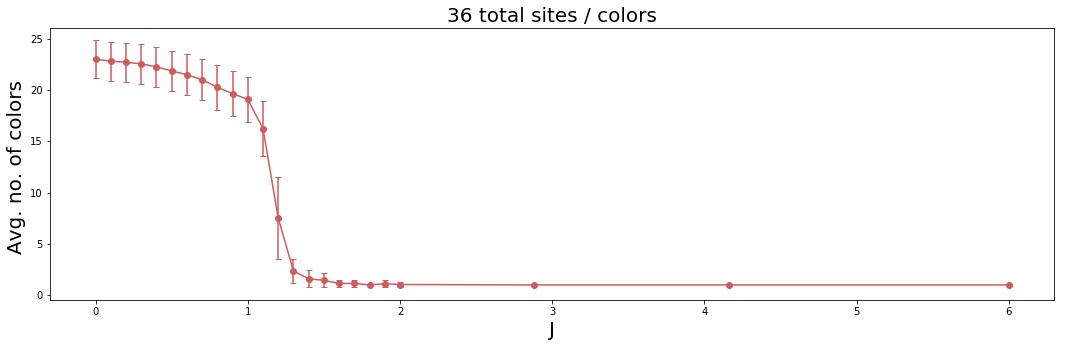

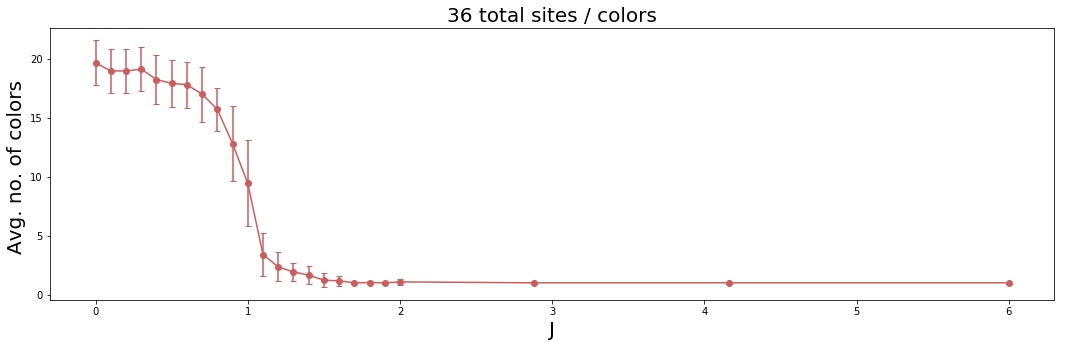

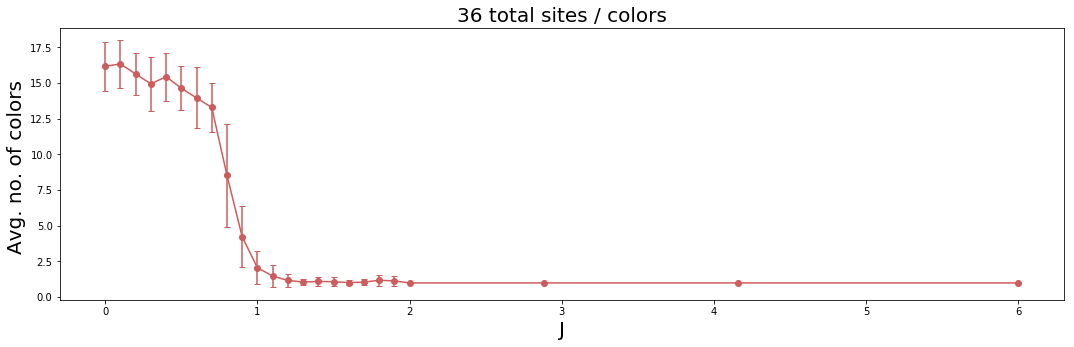

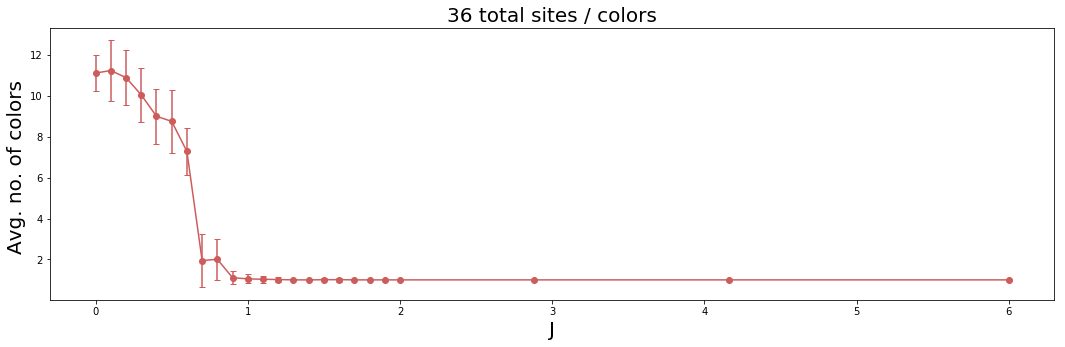

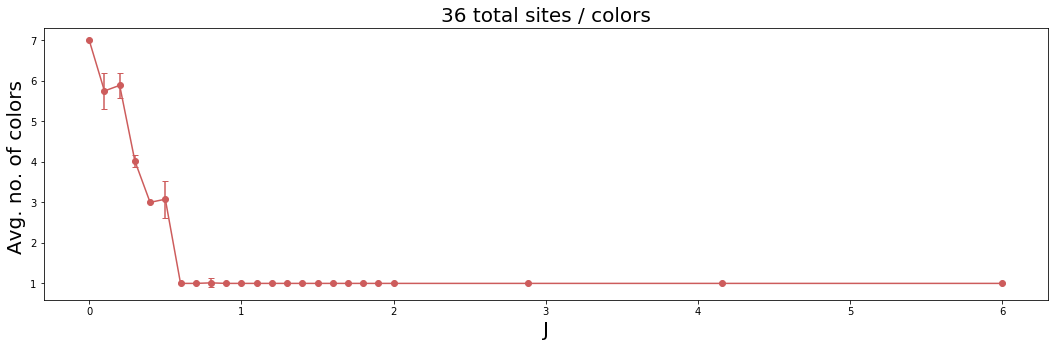

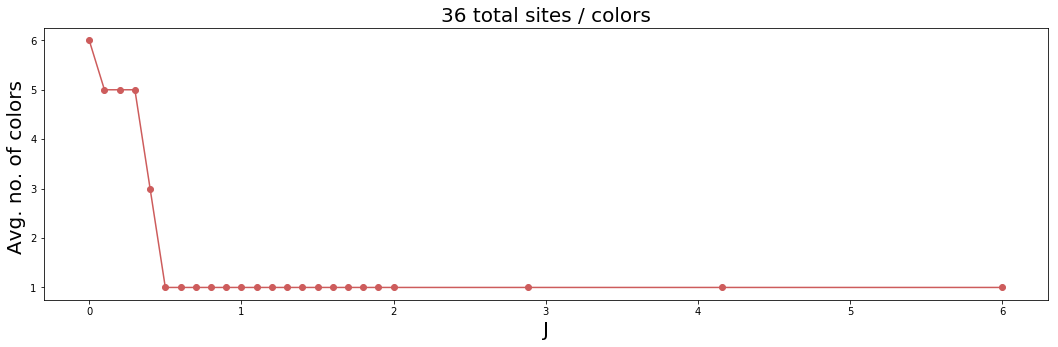

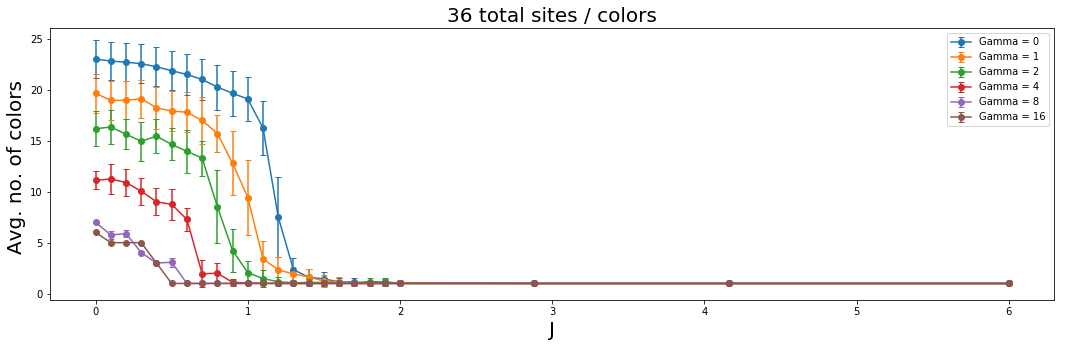

In [31]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 6

k=0
ngamma = 6
params, avg_c, std_c = [], [], []
gammas = [0,1,2,4,8,16]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

In [ ]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 7

k=0
ngamma = 6
params, avg_c, std_c = [], [], []
gammas = [0,1,2,4,8,16]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[48 28 41 10 13 31 32]
 [22 32  8 45 48 22 21]
 [37 24 20 43 29 18 37]
 [31  3 18 26 12 48 14]
 [17 24 17  5 30 16 19]
 [40 37 17  3 44 24 34]
 [45 24 24 48  9 41 44]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 29.0 avg. sites per col: 1.6896551724137931
101 num. cols: 30.435643564356436 avg. sites per col: 1.6173127455958187
201 num. cols: 30.258706467661693 avg. sites per col: 1.628355795274019
301 num. cols: 30.13621262458472 avg. sites per col: 1.6350214409229555
401 num. cols: 30.107231920199503 avg. sites per col: 1.6365559774795013
501 num. cols: 30.03393213572854 avg. sites per col: 1.6403336378135083
601 num. cols: 30.104825291181363 avg. sites per col: 1.636632955853745
701 num. cols: 30.121255349500714 avg. sites per col: 1.635740218120796
801 num. cols: 30.082397003745317 avg. sites per col: 1.6378987675499443
901 num. cols: 30.09211986681465 avg. sites per col: 1.6373726591358368
1001 num. cols: 30.055944055944057 avg. sites per col: 1.6396780808131475
Final configuration:
[[ 2 43 33  5 48 22 17]
 [22 41 37 24 32 21 22]
 [41 38 30 30 30 46 14]


201 num. cols: 26.19402985074627 avg. sites per col: 1.8834649208912269
301 num. cols: 26.358803986710964 avg. sites per col: 1.8756187574902425
401 num. cols: 26.384039900249377 avg. sites per col: 1.8747786798325823
501 num. cols: 26.481037924151696 avg. sites per col: 1.8668870532874249
601 num. cols: 26.565723793677204 avg. sites per col: 1.860775886367085
701 num. cols: 26.55206847360913 avg. sites per col: 1.8618269678764638
801 num. cols: 26.637952559300874 avg. sites per col: 1.855367537732594
901 num. cols: 26.64816870144284 avg. sites per col: 1.8555773594257792
1001 num. cols: 26.62037962037962 avg. sites per col: 1.857725856340888
Final configuration:
[[ 5  5 10 10  3  3 24]
 [38  5 10 10 10  7 12]
 [27  8  3 46 21  8  2]
 [27 39 43 43  9 46  2]
 [26 11 47  9  9 43 12]
 [16 48 42  1  1 39  2]
 [16 48  5  5  7  7  2]]
Final averages: 26.603980099502486 1.8590039773303402
Final stds: 2.5314703963829346 0.1822162771519094
-------------------------------------------------------

601 num. cols: 1.519134775374376 avg. sites per col: 37.28674431503047
701 num. cols: 1.6904422253922968 avg. sites per col: 34.752020922491596
801 num. cols: 1.8277153558052435 avg. sites per col: 32.7737203495629
901 num. cols: 1.8501664816870145 avg. sites per col: 32.2995745467997
1001 num. cols: 1.852147852147852 avg. sites per col: 32.377039627039444
Final configuration:
[[16 16 16 16 16 16 16]
 [16 16 16 16 16 16 16]
 [16 16 16 16 16 16 16]
 [16 16 16 16 16 16 16]
 [16 16 16 16 16 16 16]
 [ 9 16 16 16 16 16 16]
 [35 16 16 16 16 16 16]]
Final averages: 1.8567164179104478 32.313184079601804
Final stds: 0.8519028535108943 13.911070772139524
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[41 28 23 14 15 39  3]
 [ 7 31  7 41  2 49 26]
 [ 8 39  6 26 31 29 49]
 [30 15 17 45 24  8 23]
 [ 3 12 34 20 47 17 21]
 [11 26 43 23  5 42 13]


101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]
 [26 26 26 26 26 26 26]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilities: [9.99756404e-01 2.43595864e-04]
Initial configuration
[[25 25 48 41 17 32 44]
 [32 12 48 29 14 24 44]
 [ 4  3  7 36 23 48  3]
 [37  9 48 37 45 19 27]
 [ 9 18 47 14 

201 num. cols: 26.65671641791045 avg. sites per col: 1.847575702839909
301 num. cols: 26.19933554817276 avg. sites per col: 1.8814405384938702
401 num. cols: 26.164588528678305 avg. sites per col: 1.8839160255044347
501 num. cols: 26.22554890219561 avg. sites per col: 1.8794046283708858
601 num. cols: 26.277870216306155 avg. sites per col: 1.8755248482938234
701 num. cols: 26.16119828815977 avg. sites per col: 1.8842552012889489
801 num. cols: 26.16729088639201 avg. sites per col: 1.884376678361455
901 num. cols: 26.195338512763595 avg. sites per col: 1.8836956833589884
1001 num. cols: 26.16883116883117 avg. sites per col: 1.8853733784037294
Final configuration:
[[ 1  4 12 34 15 20 13]
 [25 22  7 18 25 12 42]
 [46  2 12 31 38 45 34]
 [34 43 34  7  1  8  4]
 [40 19 45 16 12 20  9]
 [18 19 43 18 19 46 47]
 [44  9  6 44  4 43 49]]
Final averages: 26.16915422885572 1.8853064644740083
Final stds: 2.162834831546729 0.15683704235468585
---------------------------------------------------------

601 num. cols: 23.44758735440932 avg. sites per col: 2.109343420298476
701 num. cols: 23.51925820256776 avg. sites per col: 2.1018525094393
801 num. cols: 23.49812734082397 avg. sites per col: 2.1062557708472465
901 num. cols: 23.359600443951166 avg. sites per col: 2.119457688500696
1001 num. cols: 23.442557442557444 avg. sites per col: 2.111551656820151
Final configuration:
[[19  1 34 39 24 36 23]
 [26 37 37 39 34 34 25]
 [24 30  6 19 35 22 37]
 [35 30 43  9 40  3  1]
 [26 40 36 42  3  3 39]
 [34 14 42 42 46 23 23]
 [39 14  1 42 22 24 40]]
Final averages: 23.4318407960199 2.1125504561959914
Final stds: 2.337788446465 0.21644567474291723
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[49 32  2 19  5  9 47]
 [37 31 43 15 48 38 17]
 [ 2 45 24 13 22 22 44]
 [ 3 21 39  7  3 36 12]
 [42  9 10 45 44 25 32]
 [21 27 33 36 26  4 41]
 [15 4

1001 num. cols: 2.6723276723276723 avg. sites per col: 21.978205128205143
Final configuration:
[[23 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [19 19 19 19 19 19 19]
 [ 8 19 19 19 19 19 19]]
Final averages: 2.67363184079602 21.955737976782764
Final stds: 1.0187062538450324 10.82292745393732
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[24 32 12 13 11 13 12]
 [17 40 35 21 28  6 18]
 [11 23 35 48 42 17 16]
 [17 42 32 48 17  5  8]
 [14 47 38 17 23 29 13]
 [ 4 34 34 10  3 22 17]
 [13 34 46  2 49 31 13]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 24.5
101 num. cols: 1.8613861386138615 avg. sites per col: 32.74752475247525


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]
 [43 43 43 43 43 43 43]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 22.0 avg. sites per col: 2.227272727272727
101 num. cols: 20.396039603960396 avg. sites per col: 2.411519346442651
201 num. cols: 20.55223880597015 avg. sites per col: 2.3978582304022
301 num. cols: 20.74418604651163 avg. sites per col: 2.374081682129156
401 num. cols: 20.48379052369077 avg. sites per col: 2.4039526925238346
501 num. cols: 20.90818363273453 avg. sites per col: 2.3579894954330185
601 num. cols: 21.512479201331114 avg. sites per col: 2.298923132602278
701 num. cols: 21.671897289586305 avg. sites per col: 2.285473497955202
801 num. cols: 21.737827715355806 avg. sites per col: 2.277591057680148
901 num. cols: 22.033296337402884 avg. sites per col: 2.2482642868217564
1001 num. cols: 21.84015984015984 avg. sites per col: 2.269747010554635
Final configuration:
[[10  5 48 42 34 10 48]
 [10 39 42 10 48  5 25]
 [24 24 45  5 34 33 26]
 [29 24 3

301 num. cols: 20.900332225913623 avg. sites per col: 2.3568682116155806
401 num. cols: 20.546134663341647 avg. sites per col: 2.3991582061867134
501 num. cols: 20.25748502994012 avg. sites per col: 2.4338028084714485
601 num. cols: 20.224625623960065 avg. sites per col: 2.4376270505691617
701 num. cols: 20.067047075606276 avg. sites per col: 2.4586139791044963
801 num. cols: 20.2334581772784 avg. sites per col: 2.438143005147145
901 num. cols: 20.065482796892343 avg. sites per col: 2.459799502703328
1001 num. cols: 20.066933066933068 avg. sites per col: 2.4589811969643702
Final configuration:
[[ 7 38 17 26 26  1  1]
 [ 7 49 17 17 26 12 12]
 [26 17 46 18 18 31 31]
 [30 30 32 17 31 32 44]
 [22 38  7  1 43 45  7]
 [18 48 30 46 45 13 32]
 [10  1 48 40 17  7 44]]
Final averages: 20.066666666666666 2.4589454509068
Final stds: 1.676448904288432 0.2053937654677155
------------------------------------------------------------------------------------------------------------------------

6  - par

801 num. cols: 2.7765293383270913 avg. sites per col: 27.918556665279397
901 num. cols: 2.7436182019977804 avg. sites per col: 27.10406646935487
1001 num. cols: 2.739260739260739 avg. sites per col: 26.60569153069134
Final configuration:
[[37 37 37 37 37 37 17]
 [37 37 37 37 37 37 32]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]
 [37 37 37 37 37 37 37]]
Final averages: 2.7402985074626867 26.56480652294066
Final stds: 1.7583398746753698 15.918299012324399
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
Initial configuration
[[25 44 40 24 27 41 25]
 [29 36  4 14 37 36 17]
 [36 36 41 22 12 41 38]
 [ 6 49 16 13  8 42 40]
 [ 7 21 15 12 29 15 19]
 [31 39 38 38 44 41 46]
 [42 40 41 14 45 27 49]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step:

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0748129675810474 avg. sites per col: 47.16708229426434
501 num. cols: 1.1676646706586826 avg. sites per col: 44.89221556886228
601 num. cols: 1.139767054908486 avg. sites per col: 45.5757071547421
701 num. cols: 1.1198288159771754 avg. sites per col: 46.0641940085592
801 num. cols: 1.104868913857678 avg. sites per col: 46.43071161048689
901 num. cols: 1.0932297447280799 avg. sites per col: 46.71587125416204
1001 num. cols: 1.083916083916084 avg. sites per col: 46.94405594405595
Final configuration:
[[38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]
 [38 38 38 38 38 38 38]]
Final avera

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]
 [47 47 47 47 47 47 47]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 3.5
101 num. cols: 14.009900990099009 avg. sites per col: 3.4976897689768975
201 num. cols: 14.348258706467663 avg. sites per col: 3.4187396351575403
301 num. cols: 13.87375415282392 avg. sites per col: 3.5488968395945126
401 num. cols: 13.680798004987532 avg. sites per col: 3.5978003708676902
501 num. cols: 13.50499001996008 avg. sites per col: 3.6459900711397513
601 num. cols: 13.582362728785357 avg. sites per col: 3.623042791927966
701 num. cols: 13.593437945791726 avg. sites per col: 3.6185485935842507
801 num. cols: 13.565543071161049 avg. sites per col: 3.6249239732385883
901 num. cols: 13.766925638179801 avg. sites per col: 3.5771336691425617
1001 num. cols: 13.88011988011988 avg. sites per col: 3.551835005115571
Final configuration:
[[35 43 34  2  7 43 12]
 [ 1  1 12  2  2 43 43]
 [12 12 41 41 12 20 38]
 [ 1 43 40 12 

301 num. cols: 1.3521594684385383 avg. sites per col: 41.38953488372092
401 num. cols: 1.2643391521197007 avg. sites per col: 43.28740648379051
501 num. cols: 1.467065868263473 avg. sites per col: 39.57002661343967
601 num. cols: 1.4692179700499168 avg. sites per col: 39.182334997226754
701 num. cols: 1.4022824536376606 avg. sites per col: 40.58285782215874
801 num. cols: 1.352059925093633 avg. sites per col: 41.63368705784429
901 num. cols: 1.3129855715871255 avg. sites per col: 42.451257861635156
1001 num. cols: 1.2817182817182817 avg. sites per col: 43.1054778554778
Final configuration:
[[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]]
Final averages: 1.2805970149253731 43.12893864013262
Final stds: 0.573781765325411 11.194430043211911
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]
 [48 48 48 48 48 48 48]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilitie

501 num. cols: 7.0 avg. sites per col: 7.0
601 num. cols: 7.0 avg. sites per col: 7.0
701 num. cols: 7.0 avg. sites per col: 7.0
801 num. cols: 7.0 avg. sites per col: 7.0
901 num. cols: 7.0 avg. sites per col: 7.0
1001 num. cols: 7.0 avg. sites per col: 7.0
Final configuration:
[[19  1 12 21 43 12 30]
 [19 12 30 30 43 21 21]
 [35 12 19 30  1 12 43]
 [35 30 35 30 21 43 43]
 [21 19  1 12 43 43 35]
 [ 1 19  1 12 43 35 43]
 [ 1 19 21 35 21 30 21]]
Final averages: 7.0 7.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
Initial configuration
[[22 27 24 28  3 49 12]
 [27 35  6 37 26 17 22]
 [37 23 45 13  4 19 19]
 [46  8  2 47 44  2 21]
 [25 43 16 24  5 22 33]
 [49 47 48 35 21 36 15]
 [ 6  2 11  3  9  3 33]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibratio

601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]
 [44 44 44 44 44 44 44]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[16 43 37 29 23 10 47]
 [32  1 17 37 31 12 30]
 [49 22  9 28 29 41  9]
 [21 35 31 42 34 17 41]
 [35 22  7 21 13 38  7]
 [ 4 39  1 40 45 37 32]
 [17  5  3 29  8 30  7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. si

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]
 [49 49 49 49 49 49 49]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
I

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]
 [28 28 28 28 28 28 28]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 7.0
101 num. cols: 7.0 avg. sites per col: 7.0
201 num. cols: 7.0 avg. sites per col: 7.0
301 num. cols: 7.0 avg. sites per col: 7.0
401 num. cols: 7.0 avg. sites per col: 7.0
501 num. cols: 7.0 avg. sites per col: 7.0
601 num. cols: 7.0 avg. sites per col: 7.0
701 num. cols: 7.0 avg. sites per col: 7.0
801 num. cols: 7.0 avg. sites per col: 7.0
901 num. cols: 7.0 avg. sites per col: 7.0
1001 num. cols: 7.0 avg. sites per col: 7.0
Final configuration:
[[20 29 17 18 20 29 28]
 [29 20 18 48 48 29 48]
 [11 11 17 29 28 28 20]
 [11 20 20 20 18 29 20]
 [48 11 48 18 18 48 28]
 [11 20 11 11 18 48 28]
 [20 18 28 28 28 20 48]]
Final averages: 7.0 7.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925

In [30]:
bell_dict.keys()

dict_keys([(15, 11), (16, 10), (14, 7), (12, 7), (10, 6), (9, 5), (8, 5), (7, 5), (6, 3), (7, 3), (4, 3), (3, 3), (5, 3), (4, 4), (5, 4), (6, 4), (4, 2), (2, 2), (2, 1), (1, 1), (64, 38), (64, 37), (64, 36), (64, 35), (64, 34), (64, 33), (64, 40), (64, 39), (64, 32), (64, 31), (61, 33), (62, 33), (63, 34), (63, 35), (62, 35), (63, 32), (63, 33), (62, 36), (63, 40), (64, 41), (63, 38), (63, 39), (63, 36), (61, 38), (62, 37), (64, 29), (62, 29), (62, 32), (61, 32), (63, 37), (62, 38), (64, 43), (62, 39), (60, 38), (61, 37), (62, 34), (62, 42), (63, 41), (61, 36), (14, 10), (13, 9), (11, 7), (9, 7), (8, 7), (3, 2), (3, 1), (7, 4), (6, 5), (8, 4), (36, 23), (36, 21), (36, 20), (36, 19), (36, 18), (36, 17), (36, 22), (36, 16), (36, 24), (35, 19), (35, 18), (35, 20), (35, 21), (34, 20), (35, 22), (34, 19), (34, 18), (33, 21), (32, 20), (33, 20), (34, 17), (35, 15), (34, 15), (34, 16), (34, 22), (34, 21), (35, 23), (35, 24), (35, 17), (32, 21), (30, 19), (30, 18), (32, 19), (32, 18), (33, 19)